# English final filtering of articles to embed

Note that this will be done using pageviews as a proxy for quality articles. 

The english wikipedia does have a list of **good articles** that we may want to consider keeping in addition to the pageviews proxy, though hopefully the pageviews proxy will contain most of the good articles. 



In [1]:
import os
import duckdb
from IPython.display import display


base_datadir = "../../data/"
duckdb_file = base_datadir + "db_files/wikipedia_articles_en.duckdb"
pageviews_file = base_datadir + "wikipedia_meta/aggregated/en.wikipedia_monthly_views.parquet"


os.path.exists(duckdb_file)

con = duckdb.connect(duckdb_file)

df_tables = con.sql("SHOW TABLES").df()
display(df_tables)


,name
0,articles
1,pageviews
2,pageviews_aggregated
3,pageviews_aggregated_top_articles
4,pageviews_top500k


In [2]:
df = con.sql("SELECT * FROM articles LIMIT 100").df()
df.head(3)

,page_id,title,url,word_count,outlink_count,category_count,categories,template_count,external_link_count,last_modified,processed_text,title_match
0,28438779,Alfonso III of Aragon,https://en.wikipedia.org/wiki/Alfonso_III_of_A...,432,58,11,Category:1265 births|Category:1291 deaths|Cate...,25,1,2024-05-02 13:02:49,\n\n\n\nAlfonso III (4 November 1265 – 18 June...,alfonso iii of aragon
1,42806011,Alfonso IV of Aragon,https://en.wikipedia.org/wiki/Alfonso_IV_of_Ar...,860,99,8,Category:1299 births|Category:1336 deaths|Cate...,36,1,2024-08-15 18:29:11,"\n\n\nAlfonso IV, called the Kind (also the Ge...",alfonso iv of aragon
2,43147063,Amasis II,https://en.wikipedia.org/wiki/Amasis_II,1805,95,6,Category:6th-century BC pharaohs|Category:Phar...,40,18,2024-09-18 06:14:34,"\n\nAmasis II ( ; ḤMS)Schmitz, Philip C.. ""Ch...",amasis ii


### Drop cols/views for rerunnability of notebook



In [3]:
con.execute("""
    DROP TABLE IF EXISTS pageviews_aggregated_top_articles;
    DROP TABLE IF EXISTS pageviews_aggregated;
    DROP TABLE IF EXISTS articles_unique;
    DROP TABLE IF EXISTS pageviews;
            
    DROP VIEW IF EXISTS pageviews_top500k;
""")


if "title_match" in df.columns:
    con.execute("ALTER TABLE articles DROP COLUMN title_match;")




### Add pageviews data to duckdb database

In [4]:
import pandas as pd

# Load pageviews data using DuckDB's Parquet support
con.execute(f"""
    CREATE TABLE IF NOT EXISTS pageviews AS
    SELECT *
    FROM read_parquet('{pageviews_file}')
""")

# Verify the pageviews table
print("Pageviews table schema:")
print(con.execute("DESCRIBE pageviews").fetchdf())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Pageviews table schema:
     column_name column_type null   key default extra
0      wiki_code     VARCHAR  YES  None    None  None
1  article_title     VARCHAR  YES  None    None  None
2          views      BIGINT  YES  None    None  None
3       page_ids   VARCHAR[]  YES  None    None  None


### Now create the title_match column (standardized title)

In [5]:
## about 30 seconds, not too bad

con.execute("""
ALTER TABLE pageviews
ADD COLUMN title_match VARCHAR
""")

con.execute("""
ALTER TABLE articles
ADD COLUMN title_match VARCHAR
""")


con.execute("""
    UPDATE pageviews
    SET title_match = LOWER(TRIM(REPLACE(article_title, '-', '')))
""")

con.execute("""
    UPDATE articles
    SET title_match = LOWER(TRIM(REPLACE(title, '-', '')))
""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [6]:
df = con.sql("SELECT * FROM articles LIMIT 100").df()
df_pageviews = con.sql("SELECT * FROM pageviews LIMIT 100").df()

display(df.head(3))
display(df_pageviews.head(3))

,page_id,title,url,word_count,outlink_count,category_count,categories,template_count,external_link_count,last_modified,processed_text,title_match
0,28438779,Alfonso III of Aragon,https://en.wikipedia.org/wiki/Alfonso_III_of_A...,432,58,11,Category:1265 births|Category:1291 deaths|Cate...,25,1,2024-05-02 13:02:49,\n\n\n\nAlfonso III (4 November 1265 – 18 June...,alfonso iii of aragon
1,42806011,Alfonso IV of Aragon,https://en.wikipedia.org/wiki/Alfonso_IV_of_Ar...,860,99,8,Category:1299 births|Category:1336 deaths|Cate...,36,1,2024-08-15 18:29:11,"\n\n\nAlfonso IV, called the Kind (also the Ge...",alfonso iv of aragon
2,43147063,Amasis II,https://en.wikipedia.org/wiki/Amasis_II,1805,95,6,Category:6th-century BC pharaohs|Category:Phar...,40,18,2024-09-18 06:14:34,"\n\nAmasis II ( ; ḤMS)Schmitz, Philip C.. ""Ch...",amasis ii


,wiki_code,article_title,views,page_ids,title_match
0,en.wikipedia,!,957,"[7712754, 5878274]",!
1,en.wikipedia,!!,547,"[null, 3632887]",!!
2,en.wikipedia,!!!,3730,"[null, 600744]",!!!


### Create the aggregated pageviews table

The aggregated pageviews table is what we would typically think of as just the normal pageviews table.

The reason is that the datadump has only aggregated on the day level, while we have multiple months of data, and we want to have a basic mapping of total pageviews per article. 

NOTE: each page can have multiple page_ids, this can happen with redirects, maybe something else too?



In [7]:
# about 1min 10s

# Aggregate pageviews by title_match
con.execute("""
    CREATE TABLE IF NOT EXISTS pageviews_aggregated AS
    SELECT 
        title_match,
        SUM(views) AS total_views,
        LISTAGG(DISTINCT page_ids) AS aggregated_page_ids
    FROM pageviews
    GROUP BY title_match
""")

# Verify the aggregated data
print("Aggregated Pageviews:")

df_grouped = con.sql("SELECT * FROM pageviews_aggregated order by total_views desc LIMIT 100").df()
df_grouped.head(3)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Aggregated Pageviews:


,title_match,total_views,aggregated_page_ids
0,main_page,1.760785e+09,"[11228042],[63824523, 59153, 36484, 63079188, ..."
1,special:search,5.575575e+08,"[null, 59153, 20646122, 19898, 19386149, 11429..."
2,,3.395360e+08,"[13270687, 18973788],[1452809, 68713497, 15462..."


### Create a table of the top N articles by pageviews (top 500K?)

Choose a larger number than we will embed, since we might filter out some of these..  

I.e. if the target to embed is 100K articles, be very safe and choose 500K.   

We can then further filter down from this set.



In [8]:
# about 1 min 10s

VIEW_LIMIT = 700_000

# Create table of top 500K articles by pageviews with their metadata
con.execute(f"""
CREATE VIEW IF NOT EXISTS pageviews_top500k AS
SELECT 
    title_match,
    SUM(views) AS total_views,
    LISTAGG(DISTINCT page_ids) AS aggregated_page_ids
FROM pageviews
GROUP BY title_match
ORDER BY SUM(views) DESC
LIMIT {str(VIEW_LIMIT).replace("_", "")};
""")

# Step 2: Join with articles to create the final table
con.execute("""
CREATE TABLE IF NOT EXISTS pageviews_aggregated_top_articles AS
WITH ranked_articles AS (
    SELECT 
        a.*,
        p.total_views,
        p.aggregated_page_ids,
        'https://no.wikipedia.org/w/index.php?curid=' || a.page_id as url_pageviews,
        PERCENT_RANK() OVER (ORDER BY p.total_views DESC) as views_percentile,
        ROW_NUMBER() OVER (PARTITION BY a.title_match ORDER BY a.word_count DESC) as rn
    FROM articles a
    INNER JOIN pageviews_top500k p ON a.title_match = p.title_match
)
SELECT 
 *
FROM ranked_articles
WHERE rn = 1;
""")


print("Top Articles with Pageviews:")
df_top_articles = con.sql("""
    SELECT *
    FROM pageviews_aggregated_top_articles 
    ORDER BY total_views DESC 
    LIMIT 100
""").df()
display(df_top_articles.head(5))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Top Articles with Pageviews:


,page_id,title,url,word_count,outlink_count,category_count,categories,template_count,external_link_count,last_modified,processed_text,title_match,total_views,aggregated_page_ids,url_pageviews,views_percentile,rn
0,19404073,--,https://en.wikipedia.org/wiki/--,100,12,0,,3,0,2024-07-16 16:39:45,"\n--, a string of two hyphen-minus characters,...",,339535996.0,"[1452809, 68713497, 1546216, 907691, 12686647,...",https://no.wikipedia.org/w/index.php?curid=194...,0.000000,1
1,299135,YouTube,https://en.wikipedia.org/wiki/YouTube,17507,1244,23,Category:YouTube|Category:2005 establishments ...,802,1029,2024-10-04 20:25:03,\n\n\n\n\n\n\n\nYouTube is an American online...,youtube,61184976.0,"[3524766, 18021924],[3524766, 23602489],[35247...",https://no.wikipedia.org/w/index.php?curid=299135,0.000013,1
2,48474643,Cleopatra,https://en.wikipedia.org/wiki/Cleopatra,17807,1109,22,Category:Cleopatra|Category:69 BC births|Categ...,1398,140,2024-10-04 04:20:49,\n\n\n\n\n\n\n\n\n\n\nCleopatra VII Thea Philo...,cleopatra,55414365.0,"[60827],[60827, null, 1359777],[null, 57659752...",https://no.wikipedia.org/w/index.php?curid=484...,0.000026,1
3,40943757,XXXTentacion,https://en.wikipedia.org/wiki/XXXTentacion,12332,617,38,Category:XXXTentacion|Category:1998 births|Cat...,525,636,2024-09-30 13:11:39,\n\n\n\n\n\nJahseh Dwayne Ricardo Onfroy (Janu...,xxxtentacion,42377950.0,"[53039739],[null, 53039739],[53702987, 5303973...",https://no.wikipedia.org/w/index.php?curid=409...,0.000040,1
4,39604324,Pornhub,https://en.wikipedia.org/wiki/Pornhub,3624,231,10,Category:2007 establishments in Quebec|Categor...,182,277,2024-09-29 18:35:56,\n\n\n\n\nPornhub is a Canadian-owned internet...,pornhub,40291676.0,"[45492650, null, 29555076],[45492650, 32036801...",https://no.wikipedia.org/w/index.php?curid=396...,0.000053,1


In [9]:
print("Top Articles with Pageviews:")
df_top_articles = con.sql("""
    SELECT *
    FROM pageviews_aggregated_top_articles 
    ORDER BY total_views DESC 
""").df()

df_top_articles

Top Articles with Pageviews:


,page_id,title,url,word_count,outlink_count,category_count,categories,template_count,external_link_count,last_modified,processed_text,title_match,total_views,aggregated_page_ids,url_pageviews,views_percentile,rn
0,19404073,--,https://en.wikipedia.org/wiki/--,100,12,0,,3,0,2024-07-16 16:39:45,"\n--, a string of two hyphen-minus characters,...",,339535996.0,"[1452809, 68713497, 1546216, 907691, 12686647,...",https://no.wikipedia.org/w/index.php?curid=194...,0.000000,1
1,299135,YouTube,https://en.wikipedia.org/wiki/YouTube,17507,1244,23,Category:YouTube|Category:2005 establishments ...,802,1029,2024-10-04 20:25:03,\n\n\n\n\n\n\n\nYouTube is an American online...,youtube,61184976.0,"[3524766, 18021924],[3524766, 23602489],[35247...",https://no.wikipedia.org/w/index.php?curid=299135,0.000013,1
2,48474643,Cleopatra,https://en.wikipedia.org/wiki/Cleopatra,17807,1109,22,Category:Cleopatra|Category:69 BC births|Categ...,1398,140,2024-10-04 04:20:49,\n\n\n\n\n\n\n\n\n\n\nCleopatra VII Thea Philo...,cleopatra,55414365.0,"[60827],[60827, null, 1359777],[null, 57659752...",https://no.wikipedia.org/w/index.php?curid=484...,0.000026,1
3,40943757,XXXTentacion,https://en.wikipedia.org/wiki/XXXTentacion,12332,617,38,Category:XXXTentacion|Category:1998 births|Cat...,525,636,2024-09-30 13:11:39,\n\n\n\n\n\nJahseh Dwayne Ricardo Onfroy (Janu...,xxxtentacion,42377950.0,"[53039739],[null, 53039739],[53702987, 5303973...",https://no.wikipedia.org/w/index.php?curid=409...,0.000040,1
4,39604324,Pornhub,https://en.wikipedia.org/wiki/Pornhub,3624,231,10,Category:2007 establishments in Quebec|Categor...,182,277,2024-09-29 18:35:56,\n\n\n\n\nPornhub is a Canadian-owned internet...,pornhub,40291676.0,"[45492650, null, 29555076],[45492650, 32036801...",https://no.wikipedia.org/w/index.php?curid=396...,0.000053,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74492,44734349,Avicennism,https://en.wikipedia.org/wiki/Avicennism,322,31,5,Category:Avicenna|Category:Aristotelianism|Cat...,16,1,2024-08-15 07:57:19,\n\nAvicennism is a school of Islamic philosop...,avicennism,15924.0,"[null, 14918546],[14918546]",https://no.wikipedia.org/w/index.php?curid=447...,0.999947,1
74493,45687108,Hyperbaton,https://en.wikipedia.org/wiki/Hyperbaton,2164,56,6,Category:Rhetorical techniques|Category:Word o...,70,14,2024-06-01 03:52:46,"\n\nHyperbaton , in its original meaning, is a...",hyperbaton,15923.0,"[92378, null]",https://no.wikipedia.org/w/index.php?curid=456...,0.999960,1
74494,25511559,Alasdair,https://en.wikipedia.org/wiki/Alasdair,576,87,3,Category:Scottish Gaelic masculine given names...,6,0,2024-04-11 11:38:02,\nAlasdair () is a Scottish Gaelic given name....,alasdair,15923.0,"[null, 561149]",https://no.wikipedia.org/w/index.php?curid=255...,0.999960,1
74495,46892060,Angon,https://en.wikipedia.org/wiki/Angon,618,46,3,Category:Ancient weapons|Category:Germanic wea...,16,5,2023-11-19 13:46:15,"\n\n\n\nThe angon (Medieval Greek , Old High G...",angon,15923.0,"[null, 16493686]",https://no.wikipedia.org/w/index.php?curid=468...,0.999960,1


# Can now implement same filtering strategy as for smaller wikis:



In [10]:
# print("len(df_top_articles)", len(df_top_articles))
print(f"len(df_top_articles): {len(df_top_articles):,}")

from_words = 100
to_words = 200

df_merged = df_top_articles

df_merged[df_merged.word_count.between(from_words, to_words)].sort_values("word_count", ascending=True).head(2)

len(df_top_articles): 74,497


,page_id,title,url,word_count,outlink_count,category_count,categories,template_count,external_link_count,last_modified,processed_text,title_match,total_views,aggregated_page_ids,url_pageviews,views_percentile,rn
0,19404073,--,https://en.wikipedia.org/wiki/--,100,12,0,,3,0,2024-07-16 16:39:45,"\n--, a string of two hyphen-minus characters,...",,339535996.0,"[1452809, 68713497, 1546216, 907691, 12686647,...",https://no.wikipedia.org/w/index.php?curid=194...,0.000000,1
70832,1306352,1-Phenylethylamine,https://en.wikipedia.org/wiki/1-Phenylethylamine,100,13,1,Category:Phenethylamines,26,1,2024-06-01 12:31:59,\n1-Phenylethylamine is the organic compound w...,1phenylethylamine,17313.0,"[17096374],[null, 17096374],[17096374, null],[...",https://no.wikipedia.org/w/index.php?curid=130...,0.951046,1


#### Do we filter on max outlinks too?



In [11]:
import plotly.express as px


N_PLOT = 75

df_plot = df_merged.sort_values("outlink_count", ascending=False).head(N_PLOT).copy().reset_index()

display(df_plot.head(3))
px.scatter(df_plot, x=df_plot.index, y="outlink_count", hover_data=["title"])


,index,page_id,title,url,word_count,outlink_count,category_count,categories,template_count,external_link_count,last_modified,processed_text,title_match,total_views,aggregated_page_ids,url_pageviews,views_percentile,rn
0,58234,26314040,MegaCon,https://en.wikipedia.org/wiki/MegaCon,3399,5115,8,Category:Multigenre conventions|Category:Comic...,127,172,2024-10-04 01:54:29,"\n\n\nMegaCon, short for Mega Convention, is a...",megacon,23689.0,"[1580482, null],[1580482],[1580482, 6190955],[...",https://no.wikipedia.org/w/index.php?curid=263...,0.782794,1
1,2607,1248774810,Cuneiform,https://en.wikipedia.org/wiki/Cuneiform,15753,3856,14,Category:Cuneiform|Category:Sumerian language|...,4600,129,2024-10-01 12:02:43,\n\n\n\n\n\n\nCuneiform is a logo-syllabic wri...,cuneiform,633599.0,"[350137],[null, 350137],[39181]",https://no.wikipedia.org/w/index.php?curid=124...,0.035529,1
2,24583,1249267011,1944,https://en.wikipedia.org/wiki/1944,18092,3629,2,Category:1944|Category:Leap years in the Grego...,158,77,2024-10-04 01:13:01,"\n\n\n\n\n\n\n\n\n==Events==\nBelow, the event...",1944,81597.0,"[null, 34622]",https://no.wikipedia.org/w/index.php?curid=124...,0.332408,1


**I would say no, not valuable.**

In [12]:
df_merged = df_merged.sort_values(by="total_views", ascending=False)

df_merged

,page_id,title,url,word_count,outlink_count,category_count,categories,template_count,external_link_count,last_modified,processed_text,title_match,total_views,aggregated_page_ids,url_pageviews,views_percentile,rn
0,19404073,--,https://en.wikipedia.org/wiki/--,100,12,0,,3,0,2024-07-16 16:39:45,"\n--, a string of two hyphen-minus characters,...",,339535996.0,"[1452809, 68713497, 1546216, 907691, 12686647,...",https://no.wikipedia.org/w/index.php?curid=194...,0.000000,1
1,299135,YouTube,https://en.wikipedia.org/wiki/YouTube,17507,1244,23,Category:YouTube|Category:2005 establishments ...,802,1029,2024-10-04 20:25:03,\n\n\n\n\n\n\n\nYouTube is an American online...,youtube,61184976.0,"[3524766, 18021924],[3524766, 23602489],[35247...",https://no.wikipedia.org/w/index.php?curid=299135,0.000013,1
2,48474643,Cleopatra,https://en.wikipedia.org/wiki/Cleopatra,17807,1109,22,Category:Cleopatra|Category:69 BC births|Categ...,1398,140,2024-10-04 04:20:49,\n\n\n\n\n\n\n\n\n\n\nCleopatra VII Thea Philo...,cleopatra,55414365.0,"[60827],[60827, null, 1359777],[null, 57659752...",https://no.wikipedia.org/w/index.php?curid=484...,0.000026,1
3,40943757,XXXTentacion,https://en.wikipedia.org/wiki/XXXTentacion,12332,617,38,Category:XXXTentacion|Category:1998 births|Cat...,525,636,2024-09-30 13:11:39,\n\n\n\n\n\nJahseh Dwayne Ricardo Onfroy (Janu...,xxxtentacion,42377950.0,"[53039739],[null, 53039739],[53702987, 5303973...",https://no.wikipedia.org/w/index.php?curid=409...,0.000040,1
4,39604324,Pornhub,https://en.wikipedia.org/wiki/Pornhub,3624,231,10,Category:2007 establishments in Quebec|Categor...,182,277,2024-09-29 18:35:56,\n\n\n\n\nPornhub is a Canadian-owned internet...,pornhub,40291676.0,"[45492650, null, 29555076],[45492650, 32036801...",https://no.wikipedia.org/w/index.php?curid=396...,0.000053,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74492,44734349,Avicennism,https://en.wikipedia.org/wiki/Avicennism,322,31,5,Category:Avicenna|Category:Aristotelianism|Cat...,16,1,2024-08-15 07:57:19,\n\nAvicennism is a school of Islamic philosop...,avicennism,15924.0,"[null, 14918546],[14918546]",https://no.wikipedia.org/w/index.php?curid=447...,0.999947,1
74493,45687108,Hyperbaton,https://en.wikipedia.org/wiki/Hyperbaton,2164,56,6,Category:Rhetorical techniques|Category:Word o...,70,14,2024-06-01 03:52:46,"\n\nHyperbaton , in its original meaning, is a...",hyperbaton,15923.0,"[92378, null]",https://no.wikipedia.org/w/index.php?curid=456...,0.999960,1
74494,25511559,Alasdair,https://en.wikipedia.org/wiki/Alasdair,576,87,3,Category:Scottish Gaelic masculine given names...,6,0,2024-04-11 11:38:02,\nAlasdair () is a Scottish Gaelic given name....,alasdair,15923.0,"[null, 561149]",https://no.wikipedia.org/w/index.php?curid=255...,0.999960,1
74495,46892060,Angon,https://en.wikipedia.org/wiki/Angon,618,46,3,Category:Ancient weapons|Category:Germanic wea...,16,5,2023-11-19 13:46:15,"\n\n\n\nThe angon (Medieval Greek , Old High G...",angon,15923.0,"[null, 16493686]",https://no.wikipedia.org/w/index.php?curid=468...,0.999960,1


**In the case of the english wikipedia, going by only pageviews seems to work well..**

Lets just keep the roughly 75K articles here. 

## Now chunk to analyze how embeddings would go

In [28]:
"""
Choose n articles
"""
mask = ((df_merged["word_count"] > 50))
# n_articles_to_keep = len(df_merged)
# n_articles_to_keep = 25_000
n_articles_to_keep = 50_000
df_filtered = df_merged[mask].head(n_articles_to_keep)



In [29]:
import sys
import importlib
import random
sys.path.append("../../src")

from vectordb import chunk_utils
importlib.reload(chunk_utils)

pd.set_option("display.max_colwidth", 120)
pd.set_option("display.max_columns", 50)

df = df_filtered.copy()

df['chunk_size'] = [random.randint(1000, 2000) for _ in range(len(df))]


df["split_text"] = df.apply(
    lambda row: chunk_utils.split_text(
        row['processed_text'],
        chunk_size=row['chunk_size'],
        chunk_overlap=300,
        discard_chunk_n_words_cutoff=12,
        clean_whitespace=True,
        clean_html=True,
        min_words_per_chunk=45,
    ),
    axis=1
)

df["n_chunks"] = df["split_text"].apply(lambda x: len(x))
df["n_words_per_chunk"] = df["split_text"].apply(
    lambda x: [len(chunk.split()) for chunk in x]
)

print(f"Total number of chunks: {df.n_chunks.sum():,}")

df = df.sort_values("n_chunks", ascending=False)
df.head(2)


/Users/einar/progs/python/3.10.14/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning:

It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.



Total number of chunks: 753,048


,page_id,title,url,word_count,outlink_count,category_count,categories,template_count,external_link_count,last_modified,processed_text,title_match,total_views,aggregated_page_ids,url_pageviews,views_percentile,rn,chunk_size,split_text,n_chunks,n_words_per_chunk
7272,1249296276,2000s,https://en.wikipedia.org/wiki/2000s,33738,3131,5,Category:2000s|Category:20th century|Category:21st century|Category:Contemporary history|Category:2000s decade overv...,571,866,2024-10-04 05:23:25,"\n\n\n\nFile:2000s decade montage3.png|From top left, clockwise: The World Trade Center on fire and the Statue of Li...",2000s,293131.0,"[36397, null, 19671240, 34579],[null, 607345, 34579, 376856, 562706, 412483, 126896, 496660, 575321],[19671240, null...",https://no.wikipedia.org/w/index.php?curid=1249296276,0.099228,1,1318,"[File:2000s decade montage3.png|From top left, clockwise: The World Trade Center on fire and the Statue of Liberty d...",229,"[227, 182, 197, 128, 131, 157, 198, 191, 191, 195, 68, 189, 187, 60, 53, 119, 203, 163, 163, 200, 69, 125, 200, 61, ..."
6937,47999371,Contract,https://en.wikipedia.org/wiki/Contract,27356,801,2,Category:Contract law|Category:Legal documents,232,264,2024-09-30 13:08:35,\n\n\n\n\nA contract is an agreement that specifies certain legally enforceable rights and obligations pertaining to...,contract,306356.0,"[19280537],[19280537, null],[null, 19280537]",https://no.wikipedia.org/w/index.php?curid=47999371,0.094670,1,1240,[A contract is an agreement that specifies certain legally enforceable rights and obligations pertaining to two or m...,208,"[98, 114, 173, 46, 103, 145, 134, 134, 90, 151, 105, 104, 181, 200, 64, 182, 93, 112, 115, 109, 185, 100, 163, 104, ..."


<Axes: >

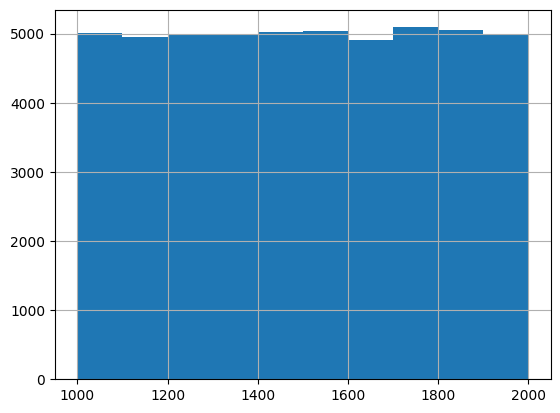

In [30]:
df.chunk_size.hist()

In [31]:
import pandas as pd
df.to_parquet("df_english_filtered_articles.cache.parquet")

df = pd.read_parquet("df_english_filtered_articles.cache.parquet")

In [32]:
"""
Info about the number of word per chunk
for the article with the most chunks
"""

import math
import numpy as np

c = df.iloc[0].n_words_per_chunk

# print some stats about c
print("mean: ", sum(c) / len(c))
print("max: ", max(c))
print("min: ", min(c))
print("median: ", np.median(c))
print("std: ", math.sqrt(sum((x - sum(c) / len(c)) ** 2 for x in c) / len(c)))

mean:  159.74235807860262
max:  251
min:  45
median:  172.0
std:  45.278748455410884


In [33]:
"""
Check the smallest chunks for the article with the most chunks
"""

for i, chunk in enumerate(df.split_text.iloc[0]):
    if len(chunk.strip().split()) < 63:
        print(chunk)
        print(chunk.strip().split())
        print(i)
        print("---")

        break

Indonesia revised and updated 1950–2008 and 2030 from International Data Base, International Programs Center, Population Division, US Bureau of the Census, April 2005 version. China's population 1990–2003 from China Statistical Yearbook 2005, China Statistics Press, Beijing. Indonesian population 1950–2003 kindly supplied by Pierre van der Eng. The figures now include three countries previously omitted: Cook Islands, Nauru and Tuvalu."	HYDE
['Indonesia', 'revised', 'and', 'updated', '1950–2008', 'and', '2030', 'from', 'International', 'Data', 'Base,', 'International', 'Programs', 'Center,', 'Population', 'Division,', 'US', 'Bureau', 'of', 'the', 'Census,', 'April', '2005', 'version.', "China's", 'population', '1990–2003', 'from', 'China', 'Statistical', 'Yearbook', '2005,', 'China', 'Statistics', 'Press,', 'Beijing.', 'Indonesian', 'population', '1950–2003', 'kindly', 'supplied', 'by', 'Pierre', 'van', 'der', 'Eng.', 'The', 'figures', 'now', 'include', 'three', 'countries', 'previously

1M chunks is surprising, it is not too much really.  
 But given the number of articles, I would have guessed around 300K chunks.  
This is based on other language wikis, so it probably just means that the avreage length of articles is longer for the english wikipedia. 



### Estimate cost of embeddings

In [34]:
# the n_words_per_chunk is a list of numbers

# df["n_words_per_chunk"] = df["n_words_per_chunk"].apply(lambda x: np.array(x))
n_words_total = df["n_words_per_chunk"].apply(np.sum).sum()

# n_words_total = sum(df.n_words_per_chunk.sum())

n_tokens_estimated = n_words_total * 1.35

n_tokens_M = n_tokens_estimated / 1_000_000

pinecone_per_1M_tokens = 0.08  # USD per 1M tokens

print(f"total number of words: {n_words_total:,}")

print(f"Estimated n token in M tokens: {n_tokens_M:.2f}")
print(f"Estimated cost for embeddings: {n_tokens_M * pinecone_per_1M_tokens:.2f} USD")



total number of words: 130,835,034
Estimated n token in M tokens: 176.63
Estimated cost for embeddings: 14.13 USD


: 